In [786]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from scipy import optimize

In [787]:
avalanche_df = pd.read_csv('snow_instability_data.csv', quoting = 3,delimiter=';')

avalanche_df.head()

,"""Date (yymmdd)",Data set,Measured crack length (m),Modeled crack length (m),Slab elastic modulus (Pa),Weak layer fracture energy (J m-2),RB score,Modeled failure initiation criterion,Weak layer strength (Pa),Slab thickness (m),"""""Observation of propagation in PST or RB (1=partial, 0=full)""""",Modeled slab tensile criterion,Slab density (kg m-3),"""""Observation of signs of instability"""""","
0,150128,"PST, SOI",0.19,0.26,6618946,0.66,NaN,696,94374,1.00,1,0.00,289,none
1,150128,"PST, SOI",0.24,0.23,5636754,0.62,NaN,489,69948,0.95,1,0.00,287,none
2,150128,"PST, SOI",0.20,0.20,4750970,0.56,NaN,406,57288,0.92,1,0.00,287,none
3,150203,"PST, SOI",0.21,0.24,1771570,0.38,NaN,268,63104,0.49,1,0.07,215,none
4,150203,"PST, SOI",0.21,0.29,1724859,0.51,NaN,213,65043,0.43,1,0.36,220,none


In [788]:
avalanche_clean_df = avalanche_df.drop(['"Date (yymmdd)', 'Data set','RB score',
                                        '""Observation of signs of instability""",'], axis=1)

avalanche_clean_df.dropna(inplace=True)
avalanche_clean_df.head()

,Measured crack length (m),Modeled crack length (m),Slab elastic modulus (Pa),Weak layer fracture energy (J m-2),Modeled failure initiation criterion,Weak layer strength (Pa),Slab thickness (m),"""""Observation of propagation in PST or RB (1=partial, 0=full)""""",Modeled slab tensile criterion,Slab density (kg m-3)
0,0.19,0.26,6618946,0.66,696,94374,1.00,1,0.00,289
1,0.24,0.23,5636754,0.62,489,69948,0.95,1,0.00,287
2,0.20,0.20,4750970,0.56,406,57288,0.92,1,0.00,287
3,0.21,0.24,1771570,0.38,268,63104,0.49,1,0.07,215
4,0.21,0.29,1724859,0.51,213,65043,0.43,1,0.36,220


In [789]:
class AvyPropogation_Neural_Net(object):
    def __init__(self,inputdf,randomSeed):
        np.random.seed(randomSeed)
        self.weights1 = np.random.randn(2,3)
        self.weights2 = np.random.randn(3,1)
        self.inputdf = inputdf
        self.inputArray = np.asarray(self.inputdf.iloc[0:,[0,1]].values)
        target = np.asarray(self.inputdf.iloc[0:,7].values)
        self.target = np.reshape(np.asarray(self.inputdf.iloc[0:,7].values), (len(target),1))
        self.resultArray = []
        
        print('weights 1:\n',self.weights1)
        print('weights 2:\n',self.weights2)

    #activation function
    def sigmoid(self,x):
        return (1/(1 + np.exp(-x)))
    
    def sigPrime(self,x):
        return (np.exp(-x)/(1+np.exp(-x))**2)
    
    def cost(self, inputArray, target):
        result = self.forwardProp(inputArray)
        return (0.5 * sum((target - result)**2))
    
    def forwardProp(self, inputArray):
        self.input_hidden = np.dot(inputArray,self.weights1)
        self.activation_hidden = self.sigmoid(self.input_hidden)
        self.hidden_output = np.dot(self.activation_hidden,self.weights2)
        result = self.sigmoid(self.hidden_output)  
        return result
        
    def backProp(self, inputArray, target):
        result = self.forwardProp(inputArray)
        #back propagation between hidden layer and result
        delta_hidden_output = np.multiply(-(target - result),self.sigPrime(self.hidden_output))
        updated_weights2 = np.dot(self.activation_hidden.T, delta_hidden_output)
        
        #back propogation between input and hidden layer
        delta_input_hidden = np.dot(delta_hidden_output, self.weights2.T) * self.sigPrime(self.input_hidden)
        updated_weights1 = np.dot(inputArray.T, delta_input_hidden)
        
        return updated_weights1, updated_weights2
            
            
    def setWeights(self, weight):
        self.weights1 = np.reshape(weight[0:(2*3)], (2,3))
        self.weights2 = np.reshape(weight[(2*3):(2*3 + 3*1)], (3,1)) 
        
        
    def gradients(self, inputArray, target):
        updated_weights1, updated_weights2 = self.backProp(inputArray,target)
        return np.concatenate((updated_weights1.ravel(), updated_weights2.ravel()))
        
        
    def callbackFunction(self, initial):
        self.setWeights(initial)
        self.resultArray.append(self.cost(self.inputArray, self.target))
        
    def minimized(self, initial, inputArray, target):
        self.setWeights(initial)
        cost = self.cost(inputArray, target)
        gradient = self.gradients(inputArray, target)
        return cost, gradient
        
    def train(self,num_training_tests = 500):
        initial0 = np.concatenate((self.weights1.ravel(), self.weights2.ravel()))
        
        training = optimize.minimize(self.minimized,initial0,jac=True,method='BFGS',args=(self.inputArray,self.target),\
                                 options={'maxiter': num_training_tests, 'disp': True}, callback=self.callbackFunction)
        
        self.setWeights(training.x)
        
        print('updated weights 1:\n',self.weights1)
        print('updated weights 2:\n',self.weights2)


In [790]:
AVPN = AvyPropogation_Neural_Net(avalanche_clean_df,1045)

AVPN.train(10000)

weights 1:
 [[ 0.22284461  1.61648749  1.60198881]
 [-0.17159116 -0.26807167  0.60798215]]
weights 2:
 [[-1.75235386]
 [-0.88645975]
 [-0.79955287]]
Optimization terminated successfully.
         Current function value: 4.174289
         Iterations: 977
         Function evaluations: 1181
         Gradient evaluations: 1181
updated weights 1:
 [[-21.11763277 -21.12552443 -21.12552562]
 [  5.35439393   5.32714831   5.32715069]]
updated weights 2:
 [[ 28348.06402661]
 [-12896.25738039]
 [-15520.42608862]]


In [791]:
output = AVPN.forwardProp(np.asarray(avalanche_clean_df.iloc[0:,[0,1]].values))


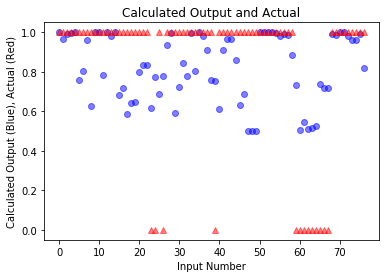

In [792]:
target = np.asarray(avalanche_clean_df.iloc[0:,7].values)
target = np.reshape(np.asarray(avalanche_clean_df.iloc[0:,7].values), (len(target),1))

plt.plot(output,'bo', target, 'r^', alpha= 0.5)
plt.xlabel('Input Number')
plt.ylabel('Calculated Output (Blue), Actual (Red)')
plt.title('Calculated Output and Actual')
plt.show()

weights 1:
 [[ 0.88389311  0.19586502  0.35753652]
 [-2.34326191 -1.08483259  0.55969629]]
weights 2:
 [[ 0.93946935]
 [-0.97848104]
 [ 0.50309684]]
         Current function value: 2.827398
         Iterations: 242
         Function evaluations: 294
         Gradient evaluations: 283
updated weights 1:
 [[  106.64036815  1341.7348963    -54.3264112 ]
 [ -168.99000344 -2351.42423235    27.85507365]]
updated weights 2:
 [[ 7002.54580566]
 [-6941.37843001]
 [ 6229.96861006]]


/Users/Spencer_Holm/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:20: RuntimeWarning: overflow encountered in square
/Users/Spencer_Holm/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:17: RuntimeWarning: overflow encountered in exp
/Users/Spencer_Holm/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:20: RuntimeWarning: overflow encountered in exp
/Users/Spencer_Holm/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:20: RuntimeWarning: invalid value encountered in true_divide
/Users/Spencer_Holm/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:17: RuntimeWarning: overflow encountered in exp
/Users/Spencer_Holm/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:20: RuntimeWarning: overflow encountered in exp
/Users/Spencer_Holm/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:20: RuntimeWarning: overflow encountered in square
/Users/Spencer_Holm/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:20: R

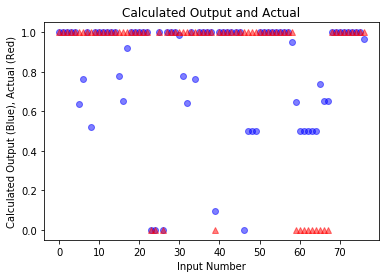

In [793]:
AVPN = AvyPropogation_Neural_Net(avalanche_clean_df,20)

AVPN.train(10000)

output = AVPN.forwardProp(np.asarray(avalanche_clean_df.iloc[0:,[0,1]].values))

target = np.asarray(avalanche_clean_df.iloc[0:,7].values)
target = np.reshape(np.asarray(avalanche_clean_df.iloc[0:,7].values), (len(target),1))

plt.plot(output,'bo', target, 'r^', alpha= 0.5)
plt.xlabel('Input Number')
plt.ylabel('Calculated Output (Blue), Actual (Red)')
plt.title('Calculated Output and Actual')
plt.show()